In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.3.1
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
matplotlib 3.3.2
numpy 1.18.4
pandas 1.1.4
sklearn 0.23.2
tensorflow 2.3.1
tensorflow.keras 2.4.0


In [2]:
# https://storage.googleapis.com/tf-datasets/titanic/eval.csv
train_file = "./data/titanic/train.csv"
eval_file = "./data/titanic/eval.csv"

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

In [3]:
train_df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
eval_df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,0,male,54.0,0,0,51.8625,First,E,Southampton,y
2,1,female,58.0,0,0,26.5500,First,C,Southampton,y
3,1,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,1,male,34.0,0,0,13.0000,Second,D,Southampton,y


In [5]:
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

In [6]:
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [7]:
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


<AxesSubplot:>

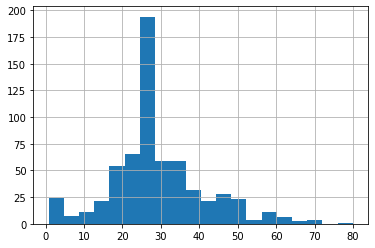

In [8]:
train_df.age.hist(bins = 20)

<AxesSubplot:>

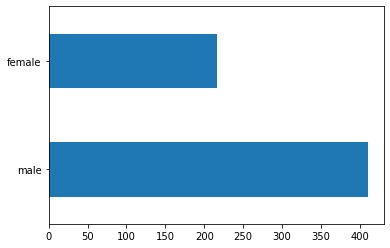

In [9]:
train_df.sex.value_counts().plot(kind = 'barh')

<AxesSubplot:>

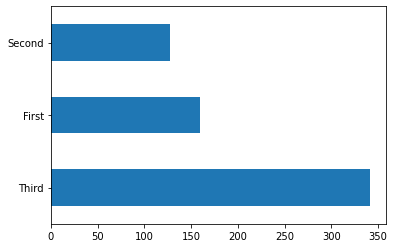

In [10]:
train_df['class'].value_counts().plot(kind = 'barh')  # 注意函数冲突

<AxesSubplot:ylabel='sex'>

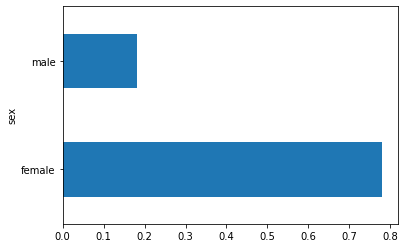

In [11]:
pd.concat([train_df, y_train], axis = 1).groupby('sex').survived.mean().plot(kind='barh')

## 模型搭建

In [12]:
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class',
                       'deck', 'embark_town', 'alone']
numeric_columns = ['age', 'fare']

feature_columns = []
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
                categorical_column, vocab)))

for numerical_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            numerical_column, dtype=tf.float32))

In [13]:
def make_dataset(data_df, label_df, epochs = 10, shuffle = True, batch_size = 32):
    dataset = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [14]:
linear_output_dir = 'linear_model'
if not os.path.exists(linear_output_dir):
    os.mkdir(linear_output_dir)
    
linear_estimator = tf.estimator.LinearClassifier(
    model_dir = linear_output_dir,
    n_classes = 2,
    feature_columns = feature_columns)
linear_estimator.train(input_fn = lambda : make_dataset(
    train_df, y_train, epochs = 100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'linear_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and grap

In [15]:
linear_estimator.evaluate(input_fn = lambda : make_dataset(
    eval_df, y_eval, epochs = 1, shuffle = False))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-12-02T11:08:43Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from linear_model\model.ckpt-1960
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.48602s
INFO:tensorflow:Finished evaluation at 2020-12-02-11:08:43
INFO:tensorflow:Saving dict for global step 1960: accuracy = 0.77272725, accuracy_b

{'accuracy': 0.77272725,
 'accuracy_baseline': 0.625,
 'auc': 0.838139,
 'auc_precision_recall': 0.79066086,
 'average_loss': 0.48586223,
 'label/mean': 0.375,
 'loss': 0.4696348,
 'precision': 0.6788991,
 'prediction/mean': 0.44033238,
 'recall': 0.74747473,
 'global_step': 1960}

In [16]:
dnn_output_dir = './dnn_model'
if not os.path.exists(dnn_output_dir):
    os.mkdir(dnn_output_dir)
dnn_estimator = tf.estimator.DNNClassifier(
    model_dir = dnn_output_dir,
    n_classes = 2,
    feature_columns=feature_columns,
    hidden_units = [128, 128],
    activation_fn = tf.nn.relu,
    optimizer = 'Adam')
dnn_estimator.train(input_fn = lambda : make_dataset(
    train_df, y_train, epochs = 100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './dnn_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in

In [17]:
dnn_estimator.evaluate(input_fn = lambda : make_dataset(
    eval_df, y_eval, epochs = 1, shuffle = False))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-12-02T11:10:26Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./dnn_model\model.ckpt-1960
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.41556s
INFO:tensorflow:Finished evaluation at 2020-12-02-11:10:26
INFO:tensorflow:Saving dict for global step 1960: accuracy = 0.7878788, accuracy_bas

{'accuracy': 0.7878788,
 'accuracy_baseline': 0.625,
 'auc': 0.84637284,
 'auc_precision_recall': 0.80834913,
 'average_loss': 0.49487495,
 'label/mean': 0.375,
 'loss': 0.47548267,
 'precision': 0.6902655,
 'prediction/mean': 0.44147304,
 'recall': 0.7878788,
 'global_step': 1960}